In [1]:
import json
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

from transformers import BartTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [2]:
PATH = json.load(open('path_config.json'))

In [3]:
xsum_bart = BARTModel.from_pretrained(PATH['bart.large.xsum'],
                                      checkpoint_file='model.pt',
                                      data_name_or_path=PATH['bart.large.xsum'])

In [4]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

#### Read XSum

In [5]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Generate Summary

In [6]:
from fairseq.data.data_utils import collate_tokens

In [7]:
class ConditionalSequenceGenerator:
    """Conditional sequence generator for calculating prior and posterior probability."""
    def __init__(self, bart):
        self.bart = bart
        self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
        
        self.encode_func = bart.encode
        self.decode_func = bart.decode
        self.max_positions = bart.max_positions
        self.encode_line = bart.task.source_dictionary.encode_line
        
        self._initialize()
    
    def _initialize(self):
        """Set BART model to evaluation mode."""
        self.bart.cuda()
        self.bart.eval()
        self.bart.half()
        
    def tokenize(self, input_str, append_bos=False, append_eos=True, left_pad=True):
        """BPE-encode a sentence (or multiple sentences).

        Args:
            input_str (str or List[str]): input sentence to be tokenized.
            append_bos (bool): self-explained.
            append_eos (bool): self-explained.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        if type(input_str) == type(''):
            input_str = [input_str]

        input_ids = []
        for ins in input_str:
            tokens = self.bart.bpe.encode(ins)  # <mask>: 1279 27932 29
            calibration = sum([append_bos, append_eos])
            if len(tokens.split(" ")) > min(self.max_positions) - calibration:
                tokens = " ".join(tokens.split(" ")[: min(self.max_positions) - calibration])

            tokens = "<s> " + tokens if append_bos else tokens
            tokens = tokens + " </s>" if append_eos else tokens
            ids = self.encode_line(tokens, append_eos=False).long()
            input_ids.append(ids)

        input_ids = collate_tokens(input_ids, pad_idx=1, left_pad=left_pad).cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()

        return input_ids, input_lengths
    
    def tokenize_with_mask(self, input_str):
        """Tokenize sentence with a special <mask> token in it.

        Args:
            input_str (str or List[str]): input sentence to be tokenized.

        Return:
            input_ids (torch.Tensor): [batch_size, length]
            src_lengths (torch.Tensor): [batch_size]
        """
        input_ids = self.tokenizer(input_str, return_tensors='pt', padding=True)['input_ids'].cuda()
        input_lengths = torch.sum(input_ids != 1, dim=1).cuda()
        return input_ids, input_lengths
    
    def generate(self, src_input, tgt_input=None):
        """Conditional generation.
        
        Args:
            src_input (str or List[str]): input source sentence to be tokenized.
            tgt_input (str or List[str]): input target sentence to be tokenized.
        """
        input_ids, lengths = self.tokenize(src_input, append_bos=False) 
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, append_bos=False, left_pad=False)
        
        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2])
        return decoder_output
    
    def mask_filling(self, src_input, tgt_input=None):
        """
        Filling the mask in sentence(s).
        """
        input_ids, lengths = self.tokenize_with_mask(src_input)
        
        target_ids = None
        if tgt_input is not None:
            assert len(src_input) == len(tgt_input), "source & target length should match."
            target_ids, _ = self.tokenize(tgt_input, left_pad=False)

        with torch.no_grad():
            encoder_output = self.encode_sequence(input_ids, lengths)
            decoder_output = self.decode_sequence(encoder_output, 
                                                  target_ids=target_ids,
                                                  prefix_tokens=[2, 0])
        return decoder_output
    
    def encode_sequence(self, input_ids, lengths):
        return self.bart.model.encoder(input_ids, src_lengths=lengths)
        
    def decode_sequence(
        self,
        encoder_out,
        target_ids=None,
        min_decode_step=3,
        max_decode_step=100,
        pad_id=1,
        eos_id=2,
        prefix_tokens=[2, 0],
    ):
        batch_size = encoder_out['encoder_padding_mask'][0].shape[0]
        init_input = torch.tensor([prefix_tokens] * batch_size, dtype=torch.long).cuda()
        token_probs, tokens = None, [[] for i in range(batch_size)]
        end_mask = torch.tensor([False] * batch_size).cuda()

        softmax = nn.Softmax(dim=1)
        for step in range(max_decode_step):
            decoder_outputs = self.bart.model.decoder(init_input, encoder_out, features_only=False)
            logits = decoder_outputs[0][:, -1, :]  # logits: [batch_size, vocab]
            attn = decoder_outputs[1]['attn'][0]  # [batch_size, prev_token_len, src_token_len]

            if step + 1 < min_decode_step:
                logits[:, eos_id] = -math.inf  # mask <EOS> token when within minimal step
            logits[:, pad_id], logits[:, 0] = -math.inf, -math.inf  # never select <PAD> & <BOS> token
            probs = softmax(logits)  # probs: [batch_size, vocab]

            # select tokens
            if target_ids is not None:
                selected_token = target_ids[:, step]
            else:
                value, indices = torch.topk(probs, 5, dim=1)
                selected_token = indices[:, 0]

            selected_token = selected_token.masked_fill(end_mask, pad_id)
            init_input = torch.cat([init_input, selected_token.unsqueeze(1)], dim=-1)
            
            probs = torch.gather(probs, 1, selected_token.unsqueeze(1)).detach()
            probs = probs.masked_fill(end_mask.unsqueeze(1), 1.0)
            
            # str & probability
            token_probs = probs if token_probs is None else torch.cat([token_probs, probs], dim=-1)
            for t, s in zip(tokens, selected_token):
                t.append(self.decode_func(s.unsqueeze(0)) if s.item() != pad_id else '<pad>')
            
            # stop generation when all finished
            end_mask = torch.logical_or(end_mask, selected_token == eos_id) 
            if end_mask.sum().item() == batch_size:
                break

        return init_input, tokens, token_probs

In [8]:
def get_probability(position, tokens, probs, entity):
    """Calculate the probability of a span.

    Args:
        position: (start, end)
        tokens: ['The', ' Archbishop', ' of', ...]
        probs: [0.50, 0.49, 0.88, ...]
        entity: Rodgers
    """
    assert len(tokens) == len(probs), "Tokens and token probabilities does not match."
    
    end_pointer, end_pos = 0, []
    for t in tokens:
        end_pointer += len(t)
        end_pos.append(end_pointer)
    
    assert position[1] in end_pos, "- {}\n- {}\n- {}\n- {}\n- {}\n".format(position, tokens, probs, entity, end_pos)
    last_index = end_pos.index(position[1])
    indexes = [last_index]
    total_length = len(tokens[last_index])
    
    while total_length < (position[1] - position[0]):
        last_index -= 1
        assert last_index >= 0
        indexes.append(last_index)
        total_length += len(tokens[last_index])
    
    indexes.reverse()
    
    generated = ''.join([tokens[i] for i in indexes])
    assert entity in generated or entity in generated.replace('Ġ', ' '), 'entity: {}; span: {}'.format(entity, generated)
    
    prob = 1.0
    for i in indexes:
        prob *= probs[i]
    return prob

In [9]:
def get_cmlm_probability(generator, src_input, tgt_input, position, entity):
    outputs = generator.generate(src_input, tgt_input=tgt_input)
    init_input, tokens, token_probs = outputs
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    
    return probs

In [10]:
def get_prior_probability(generator, src_input, tgt_input, position, entity):
    assert len(src_input) == len(tgt_input), "source & target length should match."
    decoder_output = generator.mask_filling(src_input, tgt_input)
    init_input, tokens, token_probs = decoder_output
    
    probs = []
    for p, tok, tokp, e in zip(position, tokens, token_probs, entity):
        probs.append(get_probability(p, tok, tokp, e).item())
    return probs

#### Test One Example

In [11]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [12]:
INDEX = 9444

source = xsum_source[INDEX]
target = "Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition."

In [13]:
ent_parts = nlp(target).to_json()['ents']
for e in ent_parts:
    print('{} - {}'.format(e, target[e['start']: e['end']]))

{'start': 75, 'end': 82, 'label': 'DATE'} - Cardiff


In [14]:
generator = ConditionalSequenceGenerator(xsum_bart)

In [15]:
outputs = generator.generate([source], tgt_input=[target])
print(outputs)

(tensor([[    2, 23638,   179,    12,   560,    12, 17137,   179, 30387, 15727,
         14115,    36, 14543,  2685,    43,    16,   145, 12962,    30,    10,
          1098,    11, 12426,    11,    10,  2311,     7,  1871,     5,  1074,
             9,  7272,  2421,    19,     5,  1881,     4,     2]],
       device='cuda:0'), [['Tw', 'in', '-', 'to', '-', 'tw', 'in', ' transf', 'usion', ' syndrome', ' (', 'TT', 'TS', ')', ' is', ' being', ' tracked', ' by', ' a', ' hospital', ' in', ' Cardiff', ' in', ' a', ' bid', ' to', ' save', ' the', ' lives', ' of', ' babies', ' born', ' with', ' the', ' condition', '.', '']], tensor([[0.0227, 0.8320, 0.3792, 0.9434, 0.9243, 0.7979, 0.9238, 0.9062, 0.6479,
         0.8750, 0.0133, 0.3152, 0.8843, 0.9048, 0.3230, 0.3005, 0.0776, 0.2164,
         0.5469, 0.1196, 0.8271, 0.2532, 0.0860, 0.5059, 0.8955, 0.8784, 0.0728,
         0.2229, 0.8784, 0.8901, 0.3474, 0.0228, 0.8271, 0.7759, 0.8584, 0.8950,
         0.9028]], device='cuda:0', dtype=torch.fl

In [16]:
print(get_probability((35, 39), outputs[1][0], outputs[2][0], 'TTTS'))
print(get_probability((75, 82), outputs[1][0], outputs[2][0], 'Cardiff'))

tensor(0.2788, device='cuda:0', dtype=torch.float16)
tensor(0.2532, device='cuda:0', dtype=torch.float16)


#### GPT-2 Model

In [17]:
def get_gpt2_probability(tgt_input, position, entity):
    inputs = gpt2_tokenizer(tgt_input, return_tensors="pt")
    tokens = []
    for i in inputs["input_ids"].T:
        tokens.append(gpt2_tokenizer.convert_ids_to_tokens(i)[0])
    
    with torch.no_grad():
        outputs = gpt2_model(**inputs, labels=inputs["input_ids"])
    
    output_probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    token_probs = []
    for i in range(output_probs.shape[1]):
        token_probs.append(output_probs[0][i][inputs["input_ids"][0][i]].item())
    assert len(token_probs) == len(tokens)

    probs = []
    for p, e in zip(position, entity):
        probs.append(get_probability(p, tokens, token_probs, e))
    return probs

In [18]:
inputs = gpt2_tokenizer(target, return_tensors="pt")

In [19]:
print(inputs["input_ids"].shape)
tokens = []
for i in inputs["input_ids"].T:
    tokens.append(gpt2_tokenizer.convert_ids_to_tokens(i)[0])
print(tokens)

torch.Size([1, 36])
['Tw', 'in', '-', 'to', '-', 'tw', 'in', 'Ġtransf', 'usion', 'Ġsyndrome', 'Ġ(', 'TT', 'TS', ')', 'Ġis', 'Ġbeing', 'Ġtracked', 'Ġby', 'Ġa', 'Ġhospital', 'Ġin', 'ĠCardiff', 'Ġin', 'Ġa', 'Ġbid', 'Ġto', 'Ġsave', 'Ġthe', 'Ġlives', 'Ġof', 'Ġbabies', 'Ġborn', 'Ġwith', 'Ġthe', 'Ġcondition', '.']


In [20]:
with torch.no_grad():
    outputs = gpt2_model(**inputs, labels=inputs["input_ids"])

In [21]:
outputs.logits.shape

torch.Size([1, 36, 50257])

In [22]:
output_probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(output_probs.shape)

torch.Size([1, 36, 50257])


In [23]:
# probs = []
# for i in range(output_probs.shape[1]):
#     print(gpt2_tokenizer.convert_ids_to_tokens(torch.argmax(output_probs[0][i]).unsqueeze(dim=0)))  

In [24]:
probs = []
for i in range(output_probs.shape[1]):
    probs.append(output_probs[0][i][inputs["input_ids"][0][i]].item())
print(probs)

[5.485173824126832e-05, 6.606535316677764e-05, 0.0001545079139759764, 8.277172128146049e-06, 4.0134986193152145e-05, 3.1660219974583015e-05, 1.2885796422779094e-05, 8.431362630290096e-08, 1.7848959998900682e-07, 0.0009084299672394991, 2.5551846192684025e-05, 0.015501056797802448, 0.00016067890101112425, 4.235274900565855e-05, 4.782572796102613e-05, 3.5525798011804e-05, 3.847032530757133e-06, 3.370546255609952e-05, 0.00014361921057570726, 0.0009823302971199155, 7.48443344491534e-05, 0.00012981111649423838, 6.51133741484955e-05, 0.0003103817580267787, 1.6643725757603534e-06, 9.71114423009567e-05, 4.666905078920536e-05, 0.0001213022624142468, 1.4347504020406632e-06, 7.262272265506908e-05, 7.607683073729277e-05, 0.0019340839935466647, 6.67133936076425e-05, 0.0005394196487031877, 3.7235083709674655e-06, 6.825161108281463e-06]


In [25]:
print(get_probability((35, 39), tokens, probs, 'TTTS'))

2.4906927707819143e-06


In [26]:
get_gpt2_probability(target, [(35, 39)], ['TTTS'])

[2.4906927707819143e-06]

#### Read Annotated Data

In [27]:
import json

from tqdm import tqdm

In [28]:
data = json.load(open('annotated.json', 'r'))
print(len(data))

118


In [29]:
data[5]['ents'][1]['end'] = 105

In [30]:
data[5]

{'id': 5860,
 'pred': 'The government has announced a voluntary higher rate of the London living wage, which will rise to £9.40 an hour from 1 July.',
 'ents': [{'start': 60, 'end': 66, 'label': 0, 'type': 'GPE', 'ent': 'London'},
  {'start': 100, 'end': 105, 'label': 0, 'type': 'MONEY', 'ent': '9.40'},
  {'start': 118, 'end': 124, 'label': 2, 'type': 'DATE', 'ent': '1 July'}],
 'hallucinations': ['from 1 July']}

In [31]:
def prepare_inputs(source, target, ent_parts=None):
    if ent_parts is None:
        ent_parts = nlp(target).to_json()['ents']
    
    entities, positions = [], []
    inputs, targets = [], []

    for e in ent_parts:
        positions.append((e['start'], e['end']))
        entities.append(target[e['start']: e['end']])
        inputs.append(source)
        targets.append(target)

    return inputs, targets, entities, positions

In [32]:
posterior_model = ConditionalSequenceGenerator(xsum_bart)

for INDEX in tqdm(range(len(data))):
    if INDEX in [5, 34, 67, 69]:
        continue
    source = xsum_source[data[INDEX]['id']]
    target = data[INDEX]['pred']
    
    inputs, targets, entities, positions = prepare_inputs(source, target, data[INDEX]['ents'])
    prior_probs = get_gpt2_probability(targets[0], positions, entities)
    posterior_probs = get_cmlm_probability(posterior_model, inputs, targets, positions, entities)
    
    assert len(prior_probs) == len(posterior_probs) == len(data[INDEX]['ents']), "{};\n {};\n {}".format(prior_probs, posterior_probs, data[INDEX]['ents'])
    for i in range(len(prior_probs)):
        data[INDEX]['ents'][i]['prior'] = prior_probs[i]
        data[INDEX]['ents'][i]['posterior'] = posterior_probs[i]

100%|██████████| 118/118 [01:04<00:00,  1.82it/s]


In [33]:
# import json

In [34]:
# with open('prior_posterior.json', 'w') as fout:
#     json.dump(prior_posterior , fout)

#### Draw Diagram

In [35]:
# prior_posterior = json.load(open('prior_posterior.json', 'r'))
# print(len(prior_posterior))

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt

In [37]:
prior_posterior = []
for INDEX, d in enumerate(data):
    if INDEX in [5, 34, 67, 69]: continue
    for e in d['ents']:
        e['id'] = d['id']
        prior_posterior.append(e)

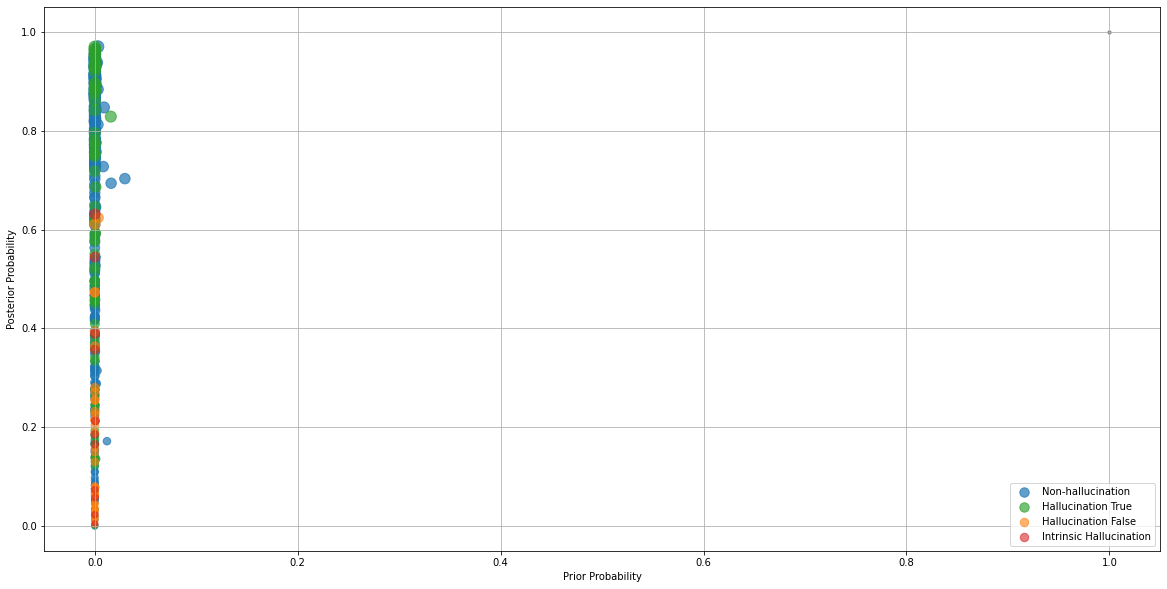

In [38]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.savefig('foo.png')
plt.show()

In [39]:
for p in prior_posterior:
    if p['prior'] > 0.9:
        print(p)

#### Classification

In [40]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'prior': 2.2716202948260076e-08,
 'posterior': 0.0927734375,
 'id': 8805}

In [41]:
true_label = []
baseline_label = []
hallucination_label = []
prob_threshold_label = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            baseline_label.append(0)
        else:
            baseline_label.append(1)

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(0)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 1 or p['label'] == 2:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))

        if p['posterior'] > p['prior']:
            prob_threshold_label.append(0)
        else:
            prob_threshold_label.append(1)

In [42]:
from sklearn.metrics import classification_report

In [43]:
print(classification_report(true_label, baseline_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.9961    0.7449    0.8523       341
     Factual     0.3359    0.9778    0.5000        45

    accuracy                         0.7720       386
   macro avg     0.6660    0.8613    0.6762       386
weighted avg     0.9191    0.7720    0.8113       386



In [44]:
print(classification_report(true_label, prob_threshold_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.8834    1.0000    0.9381       341
     Factual     0.0000    0.0000    0.0000        45

    accuracy                         0.8834       386
   macro avg     0.4417    0.5000    0.4691       386
weighted avg     0.7804    0.8834    0.8287       386



/home/mcao610/env37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print(classification_report(hallucination_label, prob_threshold_label, target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.6891    1.0000    0.8160       266
    Hallucinated     0.0000    0.0000    0.0000       120

        accuracy                         0.6891       386
       macro avg     0.3446    0.5000    0.4080       386
    weighted avg     0.4749    0.6891    0.5623       386



#### AUC

In [46]:
import numpy as np

from sklearn.metrics import roc_curve, auc

In [47]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'prior': 2.2716202948260076e-08,
 'posterior': 0.0927734375,
 'id': 8805}

In [48]:
# non-hallucination vs false hallucination

In [49]:
true_label = []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None:

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(1)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
        
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [50]:
true_label = np.asarray(true_label)
prior_probabilities = np.asarray(prior_probabilities)
posterior_probabilities = np.asarray(posterior_probabilities)

In [51]:
true_label.shape

(397,)

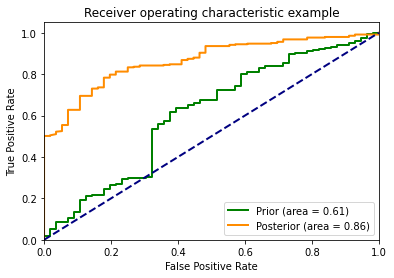

In [52]:
plt.figure()
lw = 2

# prior
fpr, tpr, _ = roc_curve(true_label, prior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
         lw=lw, label='Prior (area = %0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(true_label, posterior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Posterior (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()